<font size = "5"> **[Image Tools](2_Image_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />


# Registration of an Image Stack
<br>

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/notebooks/Imaging/Register_Image_Stack.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/pycroscopy/pyTEMlib/blob/main/notebooks/Imaging/Register_Image_Stack.ipynb)
    
part of 

<font size = "5"> **[pyTEMlib](https://pycroscopy.github.io/pyTEMlib/about.html)**</font>

a [pycroscopy](https://pycroscopy.github.io/pycroscopy/about.html) ecosystem package


Notebook by Gerd Duscher, 2023

Microscopy Facilities<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

Model based analysis and quantification of data acquired with transmission electron microscopes

## Content
An Introduction into registration of an image stack.

This works also on Google Colab.


## Prerequesites

### Install pyTEMlib

If you have not done so in the [Introduction Notebook](_.ipynb), please test and install [pyTEMlib](https://github.com/gduscher/pyTEMlib) and other important packages with the code cell below.


In [1]:
import sys

from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2023.8.1':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/pyTEMlib.git@main -q --upgrade
    
if 'google.colab' in sys.modules:
    !{sys.executable} -m pip install numpy==1.24.4
    !{sys.executable} -m pip install simpleitk
# ------------------------------
print('done')

done


**In Google Colab: Please restart runtime Ctrl+M**

### Loading of necessary libraries

Please note, that we only need to load the pyTEMlib library, which is based on sidpy Datsets. 



In [1]:
import sys
sys.path.insert(0, '../../../SciFiReaders')

import SciFiReaders
SciFiReaders.__version__


You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.


'0.0.11'

In [23]:
%matplotlib widget
import numpy as np
import matplotlib.pylab as plt 
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive

import sys
sys.path.insert(0, '../..')
%load_ext autoreload
%autoreload 2

import pyTEMlib
import pyTEMlib.file_tools as ft     # File input/ output library
import pyTEMlib.image_tools as it
import pyTEMlib.probe_tools

import skimage

if 'google.colab' in sys.modules:
    drive.mount("/content/drive")
    
# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__ = '2_Image_Registration'
__notebook_version__ = '2023_1_20'

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
pyTEM version:  0.2023.11.0


## Open File

### Choose Mode of  File Selection


The FileWidget will use display the name of a Nion File like in NionSwift. 

Select a main dataset and any additional data like reference data and such.

In [40]:
fileWidget = ft.FileWidget()

sidpy.Dataset of type IMAGE_STACK with:
 dask.array<array, shape=(29, 293, 188), dtype=float64, chunksize=(29, 293, 188), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
frame:  time (frame) of size (29,)
x:  distance (nm) of size (293,)
y:  distance (nm) of size (188,)
 with metadata: ['experiment', 'filename']

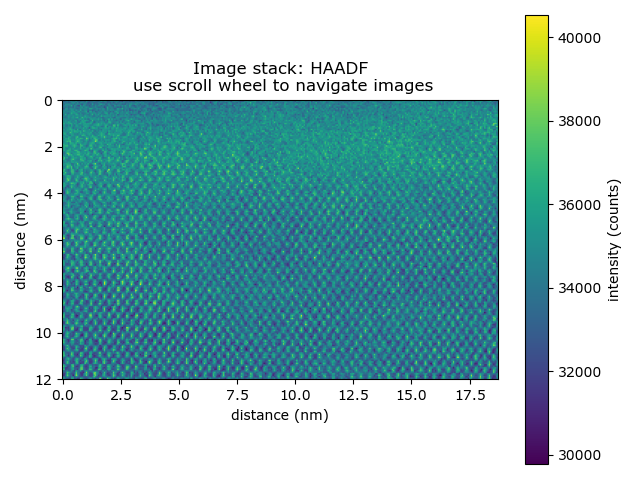

In [41]:
datasets = fileWidget.datasets
dataset = datasets['Channel_004']

if dataset.data_type.name != 'IMAGE_STACK':
    print('We really would need an image stack')

view = dataset.plot()
dataset

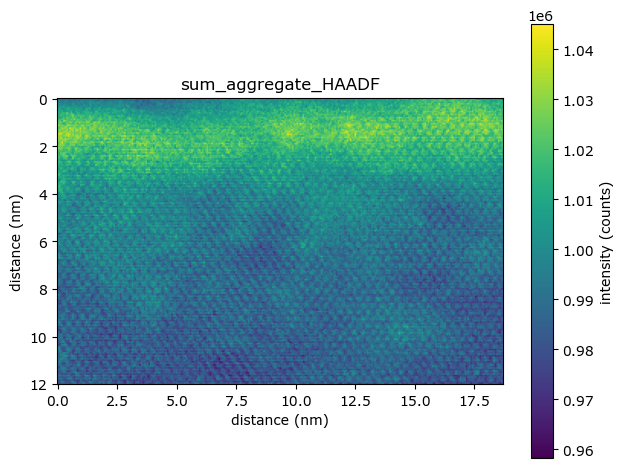

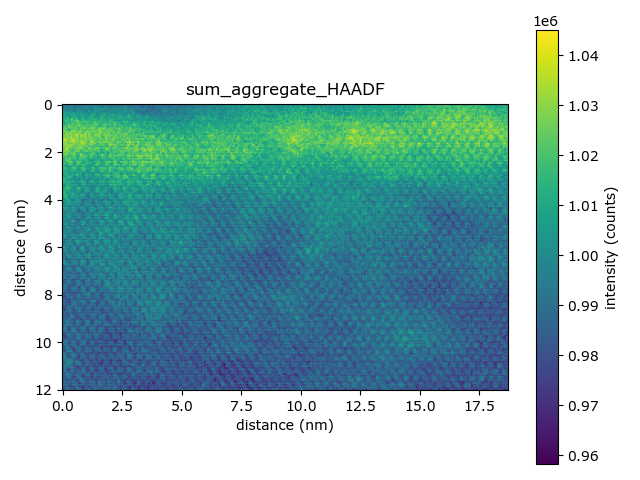

NameError: name 'axes' is not defined

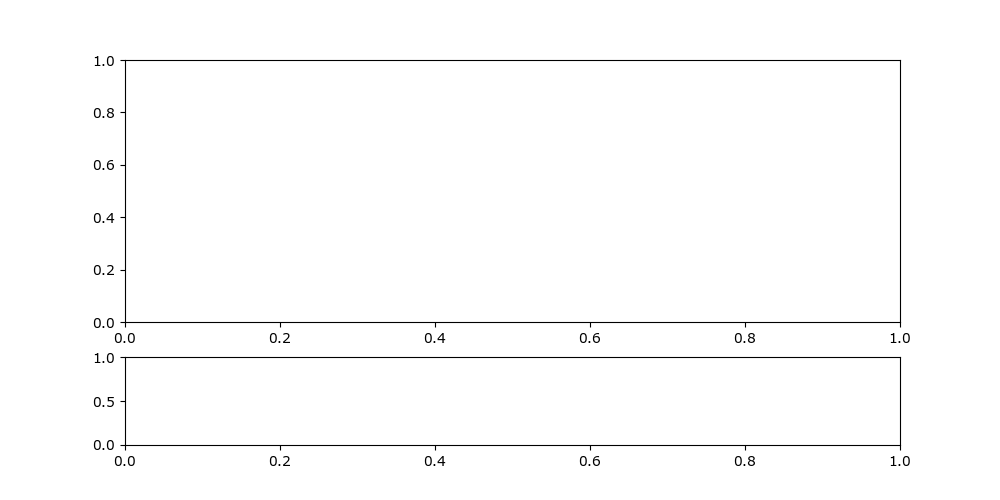

In [578]:
image = dataset.sum(axis=0)
image.data_type = 'image'


def onselect(verts):
    linewidth = selector.line_width
    image = dataset.sum(axis=0)
    length_plot = int(np.linalg.norm(selector.verts[0]-selector.verts[2]))
    
    x = np.linspace(selector.verts[2][0], selector.verts[0][0], length_plot)
    y = np.linspace(selector.verts[2][1], selector.verts[0][1], length_plot)
    linewidth_x = np.linspace(selector.verts[2][0], selector.verts[3][0], linewidth)-selector.verts[2][0]
    linewidth_y = np.linspace(selector.verts[2][1], selector.verts[3][1], linewidth)-selector.verts[2][1]

    zi2 = ndimage.map_coordinates(image.T, np.vstack((x, y)))
    for i in range(1, linewidth):
        # Extract the values along the line, using cubic interpolation
        zi2 += ndimage.map_coordinates(image.T, np.vstack((x-linewidth_x[i] , y-linewidth_y[i])))
        pass
    
    x_axis = np.linspace(0, length_plot, len(zi2))
    ax2.clear()
    ax2.plot(x_axis, zi2)
    ax2.set_xlim(0, x_axis.max())
    ax2.set_ylim(zi2.min(), zi2.max())


fig, ax = plt.subplots(2,1,figsize=(10,5), gridspec_kw={'height_ratios': [3, 1]})

lineplot = ax[1].plot([0,1], [1,2])

   
selector = pyTEMlib.image_tools.LineSelector(ax[0], onselect)
selector.set_linewidth(10)

In [558]:
class LineSelector(PolygonSelector):
    def __init__(self, ax, onselect, ax2, line_width=1, **kwargs):
        super().__init__(ax, onselect, **kwargs)
        bounds  =ax.viewLim.get_points()
        np.max(bounds[0])
        self.line_verts = np.array( [[np.max(bounds[1])/2, np.max(bounds[0])/5], [np.max(bounds[1])/2, np.max(bounds[0])/5+1],  
                                     [np.max(bounds[1])/5, np.max(bounds[0])/2], [np.max(bounds[1])/5, np.max(bounds[0])/2]])
        self.verts = self.line_verts
        self.line_width = line_width

    def set_linewidth(self, line_width):
        self.line_width = line_width

        m = -(self.line_verts[0,1]-self.line_verts[3,1])/(self.line_verts[0,0]-self.line_verts[3,0])
        c =  1/np.sqrt(1+m**2)
        s = c*m
        self.line_verts[1] = [self.line_verts[0, 0]+self.line_width*s, self.line_verts[0, 1]+self.line_width*c]
        self.line_verts[2] = [self.line_verts[3, 0]+self.line_width*s, self.line_verts[3, 1]+self.line_width*c]
        
        
        self.verts = self.line_verts.copy()
        self.onselect(self.verts)

    def onselect(verts):
        linewidth = selector.line_width
        image = dataset.sum(axis=0)
        length_plot = int(np.linalg.norm(selector.verts[0]-selector.verts[2]))
        
        x = np.linspace(selector.verts[2][0], selector.verts[0][0], length_plot)
        y = np.linspace(selector.verts[2][1], selector.verts[0][1], length_plot)
        linewidth_x = np.linspace(selector.verts[2][0], selector.verts[3][0], linewidth)-selector.verts[2][0]
        linewidth_y = np.linspace(selector.verts[2][1], selector.verts[3][1], linewidth)-selector.verts[2][1]
    
        zi2 = ndimage.map_coordinates(image.T, np.vstack((x, y)))
        for i in range(1, linewidth):
            # Extract the values along the line, using cubic interpolation
            zi2 += ndimage.map_coordinates(image.T, np.vstack((x-linewidth_x[i] , y-linewidth_y[i])))
            pass
        
        x_axis = np.linspace(0, length_plot, len(zi2))
        ax2.clear()
        ax2.plot(x_axis, zi2)
        ax2.set_xlim(0, x_axis.max())
        ax2.set_ylim(zi2.min(), zi2.max())

    def onmove(self, event):
        super().onmove(event)
        if np.max(np.linalg.norm(self.line_verts-self.verts, axis=1))>1:
            self.moved_point = np.argmax(np.linalg.norm(self.line_verts-self.verts, axis=1))
            
            self.new_point = self.verts[self.moved_point]
            moved_point = int(np.floor(self.moved_point/2)*3)
            self.moved_point = moved_point
            self.line_verts[moved_point] = self.new_point
            m = -(self.line_verts[0,1]-self.line_verts[3,1])/(self.line_verts[0,0]-self.line_verts[3,0])
            c =  1/np.sqrt(1+m**2)
            s = c*m
            self.line_verts[1] = [self.line_verts[0, 0]+self.line_width*s, self.line_verts[0, 1]+self.line_width*c]
            self.line_verts[2] = [self.line_verts[3, 0]+self.line_width*s, self.line_verts[3, 1]+self.line_width*c]
            
            self.verts = self.line_verts.copy()

            
        

In [563]:
plt.close('all')

In [540]:
bounds  =ax.viewLim.get_points()
bounds


array([[ -0.5, 292.5],
       [187.5,  -0.5]])

In [447]:
np.array(dataset).shape

(29, 293, 188)

In [462]:
import scipy.ndimage as ndimage
image = dataset.sum(axis=0)
length_plot = int(np.linalg.norm(selector.verts[0]-selector.verts[2]))
x = np.linspace(selector.verts[2][0], selector.verts[0][0], length_plot)
y = np.linspace(selector.verts[2][1], selector.verts[0][1], length_plot)

# Extract the values along the line, using cubic interpolation
zi2 = ndimage.map_coordinates(image.T, np.vstack((x, y)))

x_axis = np.linspace(0, length_plot, len(zi2))
ax2.clear()
ax2.plot(x_axis, zi2)
ax2.set_xlim(0, x_axis.max())
ax2.set_ylim(zi2.min(), zi2.max())
#ax2.draw()

(981400.2762924504, 1033777.5516946968)

In [173]:
#new_point = selector.verts[moved_point]
# moved_point = np.argmax(np.linalg.norm(line_verts-selector.verts, axis=1))
new_point, moved_point, selector.verts, line_verts

(array([30, 90]),
 1,
 [array([100,  40]),
  array([100,  41]),
  (41.70708683558868, 121.7418855361608),
  array([30, 91])],
 array([[100,  40],
        [100,  41],
        [ 30,  90],
        [ 30,  91]]))

In [140]:
print(new_point, moved_point)
if moved_point > 1:
    moved_point = 2
else:
    move_point = 0
    
line_verts[moved_point]=new_point
line_verts[moved_point+1] = new_point+np.array([0,1])
print(line_verts, new_point)
selector.verts = line_verts
line_verts

[30 90] 2
[[100  40]
 [100  41]
 [ 30  90]
 [ 30  91]] [30 90]


array([[100,  40],
       [100,  41],
       [ 30,  90],
       [ 30,  91]])

In [81]:
moved_point = np.argmax(np.linalg.norm(line_verts-selector.verts, axis=1))
print(moved_point)

selector.verts[2]=selector.verts[moved_point]
selector.verts[2]=selector.verts[moved_point]+np.array([0,1])
selector.verts[2], selector.verts[3]

2


((54.391069519571374, 118.59730837768288), array([30, 91]))

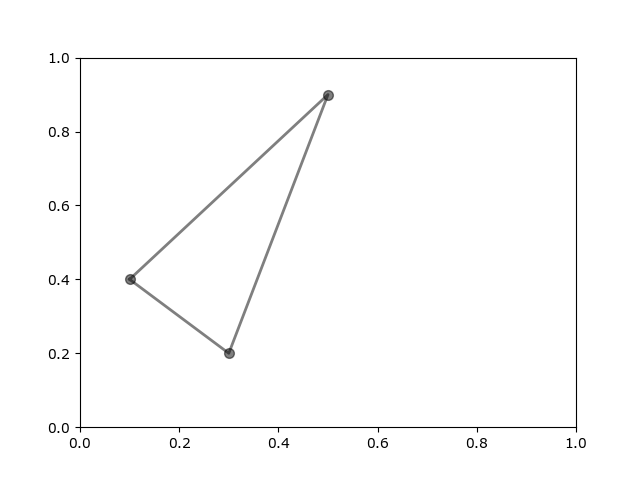

In [83]:
fig, ax = plt.subplots()


selector = PolygonSelector(ax, lambda *args: None)

# Add three vertices
selector.verts = [(0.1, 0.4), (0.5, 0.9), (0.3, 0.2)]

In [84]:
selector.verts = [(0.1, 0.4), (0.5, 0.9), (0.3, 0.2)]

In [6]:
chooser = ft.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('Channel_000: Y', 'Channel_001: Lu', 'Channel_002: Gd', 'Chan…

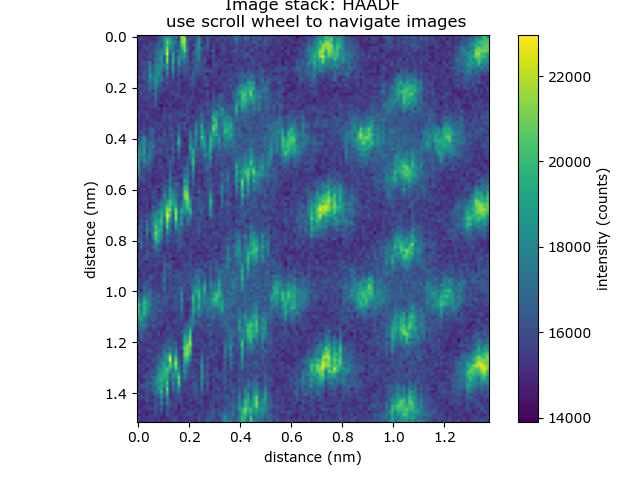

In [21]:
dataset =  chooser.dataset
view = chooser.dataset.plot()

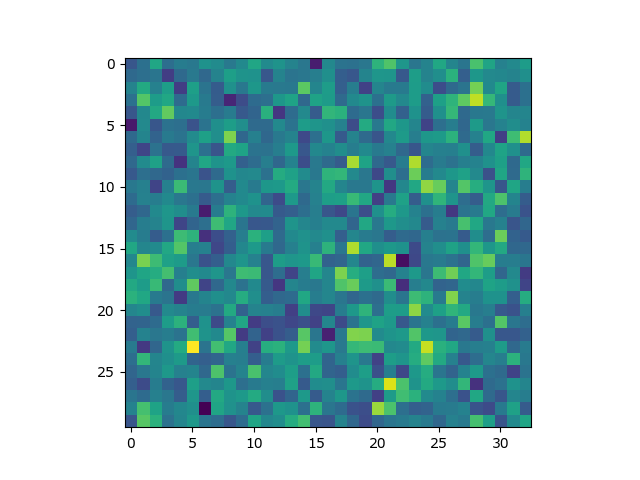

In [115]:
im = np.zeros([int(dataset.shape[0]/4), int(dataset.shape[1]/4)])
for x in range(int(dataset.shape[0]/4)):
    for y in range(int(dataset.shape[1]/4)):
        im[x,y] = dataset[x*4:x*4+4, y*4:y*4+4].sum()

plt.figure()
plt.imshow(im)

        